In [30]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
import datetime
import matplotlib.pyplot as plt

In [31]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [32]:
import pandas as pd

# Load data
file_path = r'C:\Users\rasmu\Desktop\Speciale\filtered_data6.xlsx'
df = pd.read_excel(file_path)
df['start'] = pd.to_datetime(df['start'])

print(df.shape)

# Add time-related features
df['week_of_year'] = df['start'].dt.isocalendar().week
df['month_of_year'] = df['start'].dt.month
df['year'] = df['start'].dt.year

# Rename the dataframe to filtered_df
filtered_df = df

# Display the filtered DataFrame with the new feature
print(filtered_df.shape)


(28018, 56)
(28018, 59)


Target 

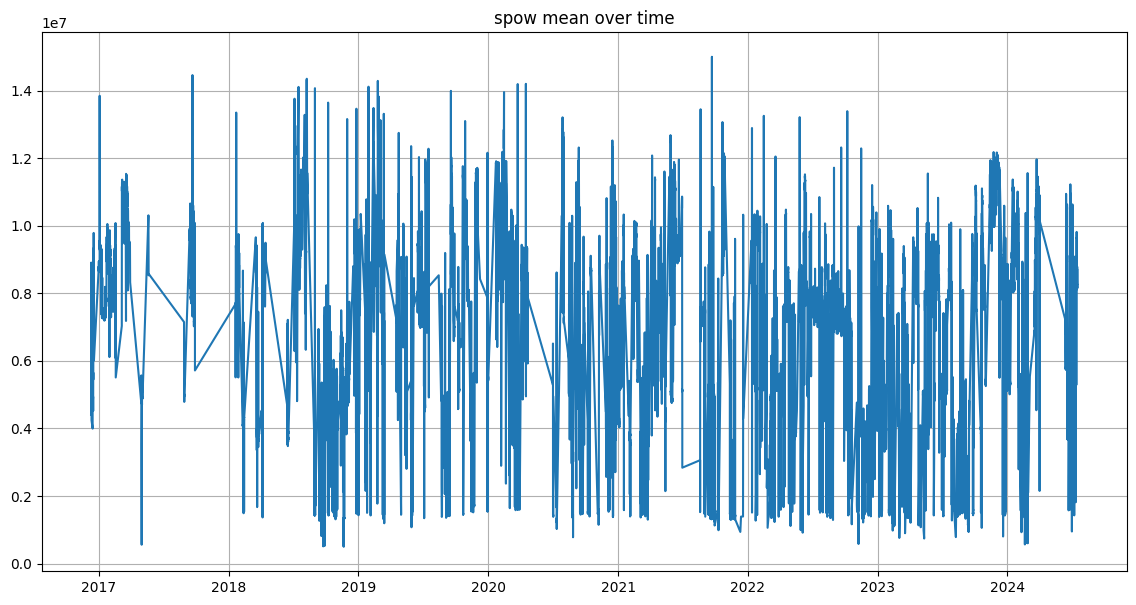

In [47]:
# plot the spow mean column over time
plt.figure(figsize=(14, 7))
plt.plot(filtered_df['start'], filtered_df['spow mean'])
plt.title('spow mean over time')
plt.grid()
plt.show()

In [33]:
# Define the reset date
reset_date = pd.Timestamp('2021-08-19')

# Calculate chronological hour since the start
filtered_df['chronological_hour'] = (filtered_df['start'] - filtered_df['start'].min()).dt.total_seconds() // 3600

# Find the index to reset the counter
reset_index = filtered_df[filtered_df['start'] >= reset_date].index[0]

# Calculate the chronological hour since the reset date
filtered_df.loc[reset_index:, 'chronological_hour'] = (filtered_df.loc[reset_index:, 'start'] - filtered_df.loc[reset_index, 'start']).dt.total_seconds() // 3600


In [34]:
import seaborn as sns

cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr = filtered_df.select_dtypes('number').corr()
corr.style.background_gradient(cmap, axis=1)\
    .format(precision=3)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_table_styles(magnify())

,lat,lat N,lon,lon N,sog mean,sog std,sog N,cog mean,cog std,cog N,stw mean,stw std,stw N,hdt mean,hdt std,hdt N,wins mean,wins std,wins N,wind mean,wind std,wind N,rud mean,rud std,rud N,pitch mean,pitch std,pitch N,roll mean,roll std,roll N,spow mean,spow std,spow N,srpm mean,srpm std,srpm N,strq mean,strq std,strq N,draught aft,draught fore,time_since_dry_dock,distance_to_equator,month_num,month_sin,month_cos,hour,day_or_night_binary,time_diff_hours,gap_indicator,gap_length_hours,week_of_year,month_of_year,year,chronological_hour
lat,1.000,0.051,-0.002,0.051,0.040,-0.117,0.051,-0.011,0.024,0.051,0.046,-0.131,0.020,-0.010,0.037,0.051,-0.026,-0.021,-0.009,0.055,-0.020,-0.009,0.061,0.028,-0.011,0.053,0.078,-0.011,0.039,-0.190,-0.011,0.072,-0.039,-0.010,0.063,-0.029,-0.010,0.069,-0.049,-0.010,0.123,0.102,0.238,-0.019,-0.232,0.231,-0.275,-0.000,-0.005,0.010,0.016,0.010,-0.229,-0.232,-0.029,0.238
lat N,0.051,1.000,-0.035,1.000,0.255,0.023,1.000,0.012,0.043,1.000,0.224,0.018,0.278,0.010,0.055,1.000,-0.052,0.006,0.287,0.037,0.047,0.287,0.008,0.010,0.287,-0.058,-0.030,0.288,0.033,-0.083,0.288,0.162,0.052,0.288,0.145,0.017,0.288,0.146,0.034,0.288,-0.075,-0.083,-0.062,-0.001,-0.027,0.039,-0.048,0.023,0.018,0.000,-0.017,0.000,-0.025,-0.027,-0.047,-0.062
lon,-0.002,-0.035,1.000,-0.035,0.087,-0.051,-0.035,-0.076,0.023,-0.035,0.090,-0.017,-0.017,-0.078,0.029,-0.035,-0.001,-0.047,-0.028,-0.035,0.011,-0.028,-0.043,-0.093,-0.027,0.107,-0.054,-0.028,0.022,-0.083,-0.028,0.114,0.018,-0.028,0.118,-0.010,-0.028,0.116,0.009,-0.028,0.112,0.131,0.187,-0.056,0.152,-0.149,-0.054,0.003,-0.012,-0.001,0.004,-0.001,0.155,0.152,-0.029,0.187
lon N,0.051,1.000,-0.035,1.000,0.255,0.023,1.000,0.012,0.043,1.000,0.224,0.018,0.278,0.010,0.055,1.000,-0.052,0.006,0.287,0.037,0.047,0.287,0.008,0.010,0.287,-0.058,-0.030,0.288,0.033,-0.083,0.288,0.162,0.052,0.288,0.145,0.017,0.288,0.146,0.034,0.288,-0.075,-0.083,-0.062,-0.001,-0.027,0.039,-0.048,0.023,0.018,0.000,-0.017,0.000,-0.025,-0.027,-0.047,-0.062
sog mean,0.040,0.255,0.087,0.255,1.000,-0.024,0.255,-0.068,-0.107,0.255,0.957,0.106,-0.004,-0.076,-0.068,0.255,-0.039,-0.040,-0.014,0.070,-0.032,-0.014,-0.108,-0.118,-0.015,0.288,0.028,-0.014,-0.033,-0.128,-0.014,0.814,0.025,-0.014,0.874,-0.208,-0.014,0.824,-0.066,-0.014,0.265,0.258,-0.053,-0.083,-0.138,0.164,-0.052,0.002,-0.026,-0.003,-0.085,-0.003,-0.138,-0.138,-0.055,-0.053
sog std,-0.117,0.023,-0.051,0.023,-0.024,1.000,0.023,0.116,0.114,0.023,-0.045,0.311,-0.097,0.114,0.095,0.023,0.038,0.122,0.009,0.034,0.054,0.009,-0.024,-0.007,0.010,0.004,-0.167,0.010,0.004,0.112,0.010,-0.052,0.226,0.009,-0.061,0.192,0.009,-0.045,0.237,0.009,-0.095,-0.064,0.003,0.108,0.071,-0.008,0.098,0.006,-0.003,0.016,0.061,0.016,0.071,0.071,-0.237,0.003
sog N,0.051,1.000,-0.035,1.000,0.255,0.023,1.000,0.012,0.043,1.000,0.224,0.018,0.278,0.010,0.055,1.000,-0.052,0.006,0.287,0.037,0.047,0.287,0.008,0.010,0.287,-0.058,-0.030,0.288,0.033,-0.083,0.288,0.162,0.052,0.288,0.145,0.017,0.288,0.146,0.034,0.288,-0.075,-0.083,-0.062,-0.001,-0.027,0.039,-0.048,0.023,0.018,0.000,-0.017,0.000,-0.025,-0.027,-0.047,-0.062
cog mean,-0.011,0.012,-0.076,0.012,-0.068,0.116,0.012,1.000,0.000,0.012,-0.069,0.066,-0.033,0.948,-0.005,0.012,0.030,-0.004,-0.004,-0.001,-0.002,-0.004,0.050,0.030,-0.004,-0.255,0.016,-0.005,0.121,0.032,-0.005,-0.118,-0.050,-0.004,-0.134,0.027,-0.004,-0.126,-0.047,-0.004,-0.251,-0.248,-0.036,-0.029,0.173,-0.161,-0.090,-0.004,0.006,-0.012,0.005,-0.012,0.159,0.173,0.105,-0.036
cog std,0.024,0.043,0.023,0.043,-0.107,0.114,0.043,0.000,1.000,0.043,-0.108,0.039,0.016,0.000,0.981,0.043,0.021,0.042,0.026,0.003,0.282,0.026,0.045,0.439,0.024,-0.049,-0.052,0.026,0.027,-0.004,0.026,-0.066,0.279,0.026,-0.094,0.282,0.026,-0.069,0.305,0.026,-0.063,-0.058,0.013,0.075,0.031,-0.022,-0.002,0.009,-0.001,0.041,0.176,0.041,0.031,0.031,-0.011,0.013
cog N,0.051,1.000,-0.035,1.000,0.255,0.023,1.000,0.012,0.043,1.000,0.224,0.018,0.278,0.010,0.055,1.000,-0.052,0.006,0.287,0.037,0.047,0.287,0.008,0.010,0.287,-0.058,-0.0

In [35]:
# Filter columns with correlation greater than 0.3 or less than -0.3 with 'spow_mean' column
relevant_columns = corr[(corr['spow mean'] > 0.3) | (corr['spow mean'] < -0.3)].index.tolist()

# add these columns to the relevant columns list time_since_dry_dock, distance_to_equator, wins mean, wind mean, roll mean, rud std
relevant_columns.extend(['stw std', 'time_since_dry_dock', 'distance_to_equator', 'wins mean', 'wind mean', 'roll mean', 'rud std', 'hdt mean', 'srpm std', 'pitch std'])

print("Columns with correlation greater than 0.3 or less than -0.3 with 'spow mean' column:")
print(relevant_columns)

Columns with correlation greater than 0.3 or less than -0.3 with 'spow mean' column:
['sog mean', 'stw mean', 'pitch mean', 'spow mean', 'srpm mean', 'strq mean', 'draught aft', 'draught fore', 'stw std', 'time_since_dry_dock', 'distance_to_equator', 'wins mean', 'wind mean', 'roll mean', 'rud std', 'hdt mean', 'srpm std', 'pitch std']


In [36]:
# Specify features and target
features = relevant_columns
target = 'spow mean'

# remove srpm and strq mean from relevant columns
features.remove('srpm mean')
features.remove('strq mean')
features.remove('spow mean')
features.remove('sog mean')

print("Features used:", relevant_columns)
print("Number of relevant_columns:", len(relevant_columns))

Features used: ['stw mean', 'pitch mean', 'draught aft', 'draught fore', 'stw std', 'time_since_dry_dock', 'distance_to_equator', 'wins mean', 'wind mean', 'roll mean', 'rud std', 'hdt mean', 'srpm std', 'pitch std']
Number of relevant_columns: 14


In [37]:
# Specify Data percentage to be used
finalDF = filtered_df
finalDF = finalDF.iloc[-(int(len(finalDF) * 1)):].reset_index(drop=True)
finalDF

,start,end,lat,lat N,lon,lon N,sog mean,sog std,sog N,cog mean,...,hour,day_or_night,day_or_night_binary,time_diff_hours,gap_indicator,gap_length_hours,week_of_year,month_of_year,year,chronological_hour
0,2016-12-10 02:00:00.170,2016-12-10 02:59:59.910,38.199641,187,-9.451396,187,5.280904,0.023678,187,-2.158236,...,2,night,0,0.999967,0,0.000000,49,12,2016,0.0
1,2016-12-10 03:00:00.053,2016-12-10 03:59:59.893,38.103435,196,-9.630567,196,5.282069,0.021103,196,-2.167541,...,3,night,0,0.999967,0,0.999967,49,12,2016,0.0
2,2016-12-10 04:00:00.080,2016-12-10 04:59:59.817,38.007906,198,-9.809803,198,5.229308,0.032610,198,-2.153006,...,4,night,0,1.000007,0,1.000007,49,12,2016,1.0
3,2016-12-10 05:00:00.177,2016-12-10 05:59:59.930,37.916905,153,-9.988157,153,5.148653,0.027065,153,-2.148171,...,5,night,0,1.000027,0,1.000027,49,12,2016,3.0
4,2016-12-10 06:00:00.023,2016-12-10 06:59:59.880,37.823293,154,-10.163574,154,5.138862,0.024928,154,-2.169517,...,6,day,1,0.999957,0,0.999957,49,12,2016,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28013,2024-07-16 00:00:00.283,2024-07-16 01:00:00.183,-18.011275,155,101.638665,155,6.508027,0.028468,155,0.999600,...,0,night,0,1.000009,0,1.000009,29,7,2024,25472.0
28014,2024-07-16 01:00:00.263,2024-07-16 02:00:00.097,-17.890781,155,101.823270,155,6.523489,0.027640,155,0.973856,...,1,night,0,0.999994,0,0.999994,29,7,2024,25473.0
28015,2024-07-16 02:00:00.157,2024-07-16 03:00:00.103,-17.775657,160,102.010480,160,6.549669,0.026675,160,1.025139,...,2,night,0,0.999971,0,0.999971,29,7,2024,25474.0
28016,2024-07-16 03:00:00.290,2024-07-16 04:00:00.047,-17.661724,156,102.201806,156,6.617430,0.027442,156,0.997207,...,3,night,0,1.000037,0,1.000037,29,7,2024,25475.0


In [38]:
# Initialize and apply scalers
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))
X = finalDF[features].values
y = finalDF[[target]].values
X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y)

In [45]:
def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps + 1):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps - 1])  # Target is the next value right after the sequence
    return np.array(Xs), np.array(ys)

time_steps = 24
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps=time_steps)

# Calculate the split index based on 80% of the dataset for training
split = int(0.85 * len(X_seq))
train_X, train_y = X_seq[:split], y_seq[:split]
val_X, val_y = X_seq[split:], y_seq[split:]

In [40]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    Bidirectional(GRU(150, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.01)), input_shape=(time_steps, len(relevant_columns))),
    Dropout(0.3),
    Bidirectional(GRU(50, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.01))),
    Dropout(0.1),
    Bidirectional(GRU(20, activation='tanh')),  # Last layer might not return sequences
    Dropout(0.4),
    Dense(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Adjust early stopping patience
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Adjust ReduceLROnPlateau settings
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)

# Check the shape of your input data
print(f"Shape of train_X: {train_X.shape}")
print(f"Shape of train_y: {train_y.shape}")
print(f"Shape of val_X: {val_X.shape}")
print(f"Shape of val_y: {val_y.shape}")

# Train the model with validation split
history = model.fit(
    train_X, train_y,
    epochs=100,  # Number of epochs for training
    validation_data=(val_X, val_y),  # Use the validation data for validation during training
    verbose=2,
    batch_size= 64,  # Batch size
    callbacks=[early_stopping, reduce_lr]
)

Shape of train_X: (25195, 24, 14)
Shape of train_y: (25195, 1)
Shape of val_X: (2800, 24, 14)
Shape of val_y: (2800, 1)
Epoch 1/100
394/394 - 156s - loss: 0.4611 - val_loss: 0.0121 - lr: 0.0010 - 156s/epoch - 395ms/step
Epoch 2/100
394/394 - 140s - loss: 0.0106 - val_loss: 0.0100 - lr: 0.0010 - 140s/epoch - 355ms/step
Epoch 3/100
394/394 - 141s - loss: 0.0085 - val_loss: 0.0071 - lr: 0.0010 - 141s/epoch - 359ms/step
Epoch 4/100
394/394 - 142s - loss: 0.0075 - val_loss: 0.0074 - lr: 0.0010 - 142s/epoch - 360ms/step
Epoch 5/100
394/394 - 142s - loss: 0.0073 - val_loss: 0.0071 - lr: 0.0010 - 142s/epoch - 360ms/step
Epoch 6/100

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
394/394 - 143s - loss: 0.0075 - val_loss: 0.0079 - lr: 0.0010 - 143s/epoch - 363ms/step
Epoch 7/100
394/394 - 143s - loss: 0.0062 - val_loss: 0.0062 - lr: 2.0000e-04 - 143s/epoch - 363ms/step
Epoch 8/100
394/394 - 142s - loss: 0.0058 - val_loss: 0.0063 - lr: 2.0000e-04 - 142s/epoch - 361ms

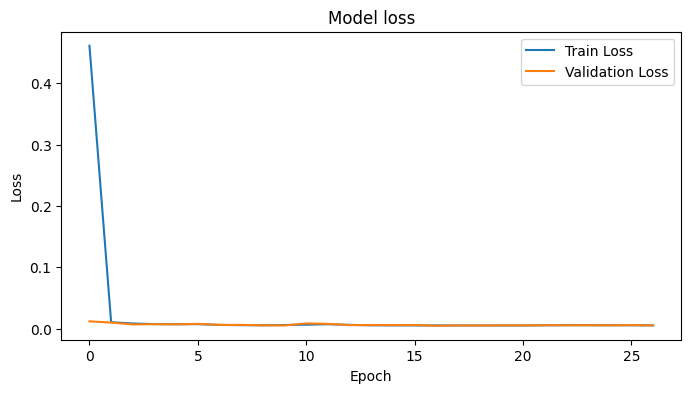

In [41]:
# Plot training & validation loss values
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [42]:
# Predict and evaluate
predictions = model.predict(val_X)
val_y_rescaled = target_scaler.inverse_transform(val_y)
predictions_rescaled = target_scaler.inverse_transform(predictions)

# Calculate metrics
mae = mean_absolute_error(val_y_rescaled, predictions_rescaled)
mse = mean_squared_error(val_y_rescaled, predictions_rescaled)
r2 = r2_score(val_y_rescaled, predictions_rescaled)
mape = np.mean(np.abs((val_y_rescaled - predictions_rescaled) / val_y_rescaled)) * 100
rmse = np.sqrt(mse)

# Print evaluation metrics
print(f"GRU MAE: {mae:.4f}")
print(f"GRU MSE: {mse:.4f}")
print(f"GRU R²: {r2:.4f}")
print(f"GRU MAPE: {mape:.4f}%")
print(f"GRU RMSE: {rmse:.4f}")

88/88 [==============================] - 6s 34ms/step
GRU MAE: 711145.8600
GRU MSE: 864669419512.3982
GRU R²: 0.8876
GRU MAPE: 11.7375%
GRU RMSE: 929876.0237


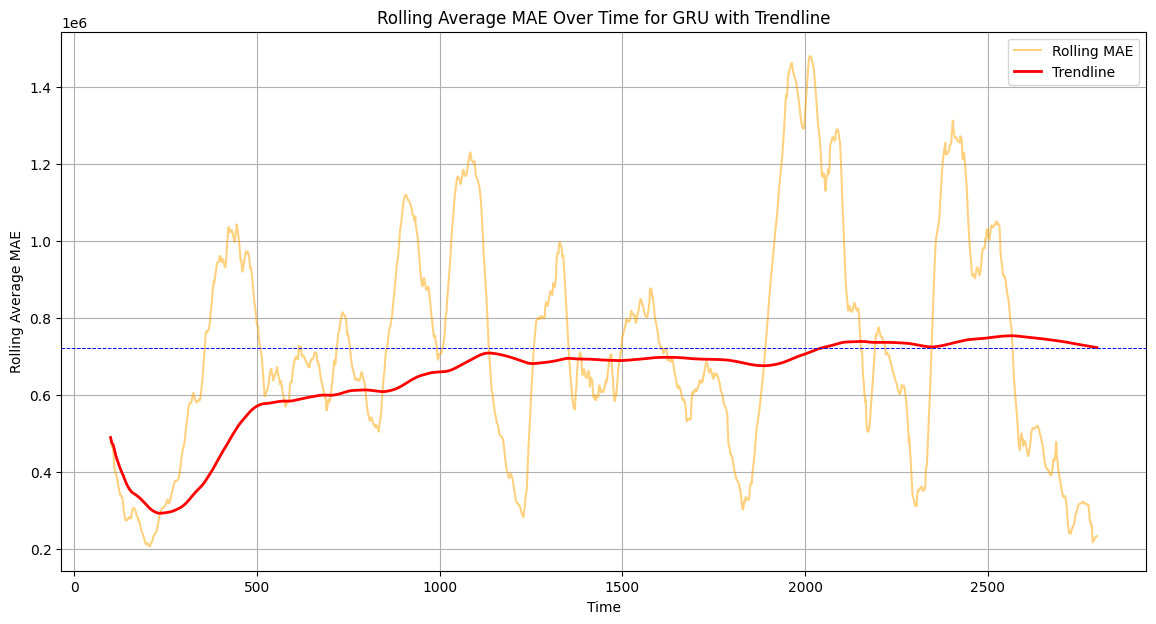

In [43]:
# Combine the actual and predicted values into one DataFrame
val_y_rescaled_df = pd.DataFrame(val_y_rescaled, columns=['Actual'])
predictions_rescaled_df = pd.DataFrame(predictions_rescaled, columns=['Predicted'])
results_df = pd.concat([val_y_rescaled_df, predictions_rescaled_df], axis=1)

# Calculate rolling MAE
rolling_window = 100  # Adjust this value to change the smoothness of the trendline
results_df['Absolute_Error'] = np.abs(results_df['Actual'] - results_df['Predicted'])
rolling_mae = results_df['Absolute_Error'].rolling(window=rolling_window).mean()

# Calculate trendline (moving average of rolling MAE)
trend_window = 2900  # Adjust this value to change the smoothness of the trendline
rolling_mae_trend = rolling_mae.rolling(window=trend_window, min_periods=1).mean()

# Plotting the Rolling Average MAE Over Time with Trendline
plt.figure(figsize=(14, 7))
plt.plot(rolling_mae, label='Rolling MAE', color='orange', alpha=0.5)
plt.plot(rolling_mae_trend, label='Trendline', color='red', linewidth=2)
plt.axhline(y=rolling_mae.mean(), color='blue', linestyle='--', linewidth=0.7)
plt.title('Rolling Average MAE Over Time for GRU with Trendline')
plt.xlabel('Time')
plt.ylabel('Rolling Average MAE')
plt.legend()
plt.grid(True)
plt.show()

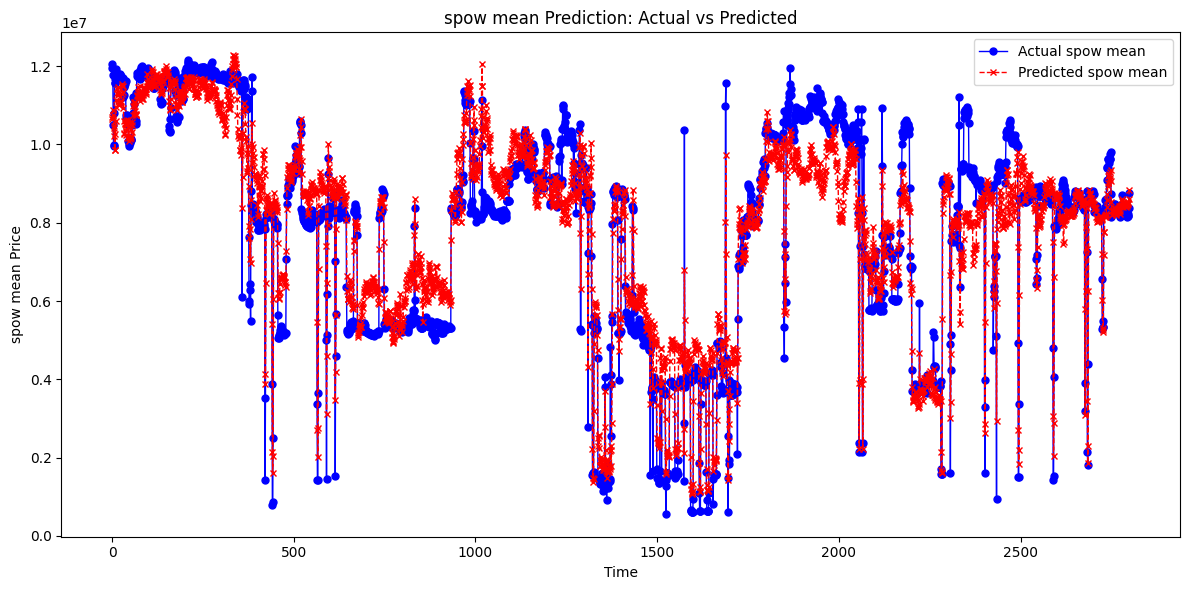

In [44]:
# Improved visualization for Actual vs Predicted Spow Mean Price
plt.figure(figsize=(12, 6))
plt.plot(val_y_rescaled, label=f'Actual {target}', color='blue', marker='o', linestyle='-', linewidth=1, markersize=5)
plt.plot(predictions_rescaled, label=f'Predicted {target}', color='red', marker='x', linestyle='--', linewidth=1, markersize=5)
plt.title(f'{target} Prediction: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel(f'{target} Price')
plt.legend()
plt.tight_layout()
plt.show()

